<a href="https://colab.research.google.com/github/antopeza/Final-Project-Brainster/blob/main/NEW_code_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os 

import re

import string
from string import punctuation

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import xgboost as xgb

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, word_tokenize

import gensim
from gensim.parsing.preprocessing import remove_stopwords

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

#from scikeras.wrappers import KerasClassifier

import pickle
from pickle import dump
from pickle import load

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive 
drive.mount('/drive')

Mounted at /drive


In [4]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
stops = set(stopwords.words('english'))
#print(stops)

In [6]:
stemmer =  PorterStemmer()
lemmer = WordNetLemmatizer()

In [ ]:
# example
print(stemmer.stem('halves'))
print(lemmer.lemmatize('halves'))

In [29]:
#df_raw = pd.read_csv(path)
df_raw = pd.read_csv('/drive/My Drive/MACHINE LEARNING/FINAL PROJECT/train.csv')

In [8]:
print('shape of df  = ', df_raw.shape)
print()
df_raw.head(2)

shape of df  =  (404290, 6)



,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [9]:
df_raw[df_raw.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [30]:
df_raw = df_raw.fillna("")
df_raw.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [49]:
# randomly selected samples from df for the new df to perform operations
df = df_raw.sample(3100)
df = df[['question1', 'question2', 'is_duplicate']]
print(df.shape)

(3100, 3)


In [39]:
df_copy = df.copy()

In [50]:
from sklearn.model_selection import train_test_split
y = df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], 
                                                                y, stratify = y, test_size = 0.2, random_state = 0)

print("Whole dataset: ", len(df))
print("X_train size =", len(X_train))
print("X_split size =", len(X_test))
print("y_train size =", len(y_train))
print("y_split size =", len(y_test))

Whole dataset:  3100
X_train size = 2480
X_split size = 620
y_train size = 2480
y_split size = 620


In [52]:
y_train = pd.DataFrame(y_train, columns=['is_duplicate'])
X_train = X_train.join(y_train, lsuffix='_left', rsuffix='_right')
X_train

,question1,question2,is_duplicate
5941,What is analog?,What is analog communication?,0
113024,Which is best porn site ever?,Which are the best porn sited?,1
58668,Can any one give suggestions which laptop shou...,Which is the best laptop below Rs 30000?,1
72141,Why is it that some insurance companies (Aetna...,I have got 60% marks in 12th and I cannot affo...,0
216879,"What is the meaning of the word ""echad""?",Is it okay for a Muslim girl to have a Hebrew ...,0
...,...,...,...
360083,What are the clues girl leaves you if she like...,How do I know if a girl likes me back or not?,1
118371,Which is a suitable inpatient drug and alcohol...,Which is a suitable inpatient drug and alcohol...,0
22403,Why cant someone stop thinking about you?,Why can't I stop thinking about someone?,0
329104,Me and my friends are going to Bangalore for 3...,What are the best night out places in Pune?,0


In [53]:
y_test = pd.DataFrame(y_test, columns=['is_duplicate'])
X_test = X_test.join(y_test, lsuffix='_left', rsuffix='_right')
X_test

,question1,question2,is_duplicate
146160,What is the best outdoor tool?,What are the coolest outdoor tools?,1
49248,What are the best ways to market online market...,What is the best way to learn marketing online?,0
190030,What was the significance of the battle of Som...,What was the significance of the battle of Som...,1
278474,What are some easy trumpet songs for a beginner?,What are some easy songs to play on the clarinet?,0
346581,How can I increase the traffic to a website?,How do I increase traffic on my site?,1
...,...,...,...
338544,What is the best thing to do to start being in...,How can I contribute to open source development?,1
43745,What are the best ways to improve my English b...,What the best way to improve English?,1
297732,Which is the best Destination for Ecotourism i...,Is there an official PC software for Android/G...,0
49087,Can dogs eat cooked eggs?,Can dogs eat cooked fish?,0


In [54]:
def get_wordnet_pos(tag):
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

def clean_sentence(sentence, stopwords = False, lemmatize = False, stem = False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)  # removing all caracters that are not alpha numeric
    #sentence = re.sub(r'\s{2,}', ' ', sentence
   
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    
    if stopwords:
        sentence = remove_stopwords(sentence)  
        
    if lemmatize:
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
        wn_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
        res_words = []
        for word, tag in wn_tagged:
            if tag is None:
                res_words.append(word)
            else :
                res_words.append(lemmer.lemmatize(word, tag))
        sentence = " ".join(res_words)
        
    if stem:
        sent_stemmed = ''
        for word in sentence.split():
            sent_stemmed += ' '+ stemmer.stem(word)
        sentence = sent_stemmed
   
    return sentence

def get_cleaned_senteces(df, stopwords = False, lemmatize = False, stem = False):
    #sents1 = dfq[['question1']]  
    #sents2 = dfq[['question2']]
    cleaned_sentences1 = []
    cleaned_sentences2 = []
    
    for index, row in df.iterrows():
        # print (index, row)
        cleaned1 = clean_sentence(row['question1'], stopwords, lemmatize, stem) 
        cleaned2 = clean_sentence(row['question2'], stopwords, lemmatize, stem)

        cleaned_sentences1.append(cleaned1)
        cleaned_sentences2.append(cleaned2)
    return cleaned_sentences1, cleaned_sentences2

In [60]:
def to_df_train(q1cleaned, q2cleaned, df):
    '''cleaned sentences to df'''
    X_temp1 = pd.DataFrame()
    X_temp2 = pd.DataFrame()
    X_temp1['q1'] = pd.DataFrame(q1cleaned, index = df.index)
    X_temp2['q2'] = pd.DataFrame(q2cleaned, index = df.index)
    X_temp = pd.concat([X_temp1_train, X_temp2_train], axis = 1)
    X_temp['is_duplicate'] = X_train['is_duplicate']
    return X_temp

In [61]:
# With stopwords lemmatized, not stemmed
q1_sw, q2_sw = get_cleaned_senteces(X_train, stopwords = False, lemmatize = True, stem = False)
assert len(q1_sw) == len(q2_sw)
X_sw_train = to_df(q1_sw, q2_sw, X_train)
X_sw_train.shape

(2480, 3)

In [62]:
# With stopwords lemmatized, not stemmed
q1_sw, q2_sw = get_cleaned_senteces(X_test, stopwords = False, lemmatize = True, stem = False)
assert len(q1_sw) == len(q2_sw)
X_sw_test = to_df(q1_sw, q2_sw, X_test)
X_sw_test.shape

(620, 3)

Value counts:
 0    1546
1     934
Name: is_duplicate, dtype: int64

Percent of labels value:
 0    62.33871
1    37.66129
Name: is_duplicate, dtype: float64


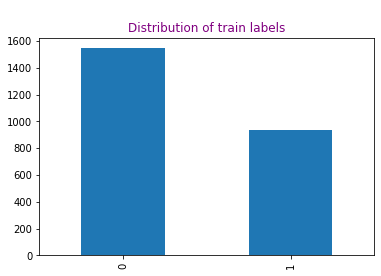

In [66]:
print('Value counts:\n', X_sw_train['is_duplicate'].value_counts())
print('\nPercent of labels value:\n', X_sw_train['is_duplicate'].value_counts()/X_sw_train['is_duplicate'].count()*100)
X_sw_train['is_duplicate'].value_counts().plot(kind = 'bar')
plt.title('\nDistribution of train labels', color = 'purple', size = 12)
plt.show()

Value counts:
 0    386
1    234
Name: is_duplicate, dtype: int64

Percent of labels value:
 0    62.258065
1    37.741935
Name: is_duplicate, dtype: float64


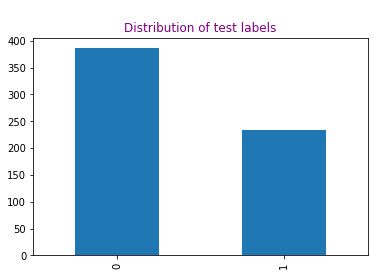

In [67]:
print('Value counts:\n', X_sw_test['is_duplicate'].value_counts())
print('\nPercent of labels value:\n', X_sw_test['is_duplicate'].value_counts()/X_sw_test['is_duplicate'].count()*100)
X_sw_test['is_duplicate'].value_counts().plot(kind = 'bar')
plt.title('\nDistribution of test labels', color = 'purple', size = 12)
plt.show()

In [68]:
display (X_sw_train.head(2))
display(X_sw_test.head(2))
display(df.head(2))

,q1,q2,is_duplicate
5941,what be analog,what be analog communication,0
113024,which be best porn site ever,which be the best porn sit,1


,q1,q2,is_duplicate
146160,what be the best outdoor tool,what be the cool outdoor tool,1
49248,what be the best way to market online marketin...,what be the best way to learn marketing online,0


,question1,question2,is_duplicate
86948,What salary can I get after HM form IHM?,How much do people who graduate from IHM in In...,0
223614,What are the symptoms of high blood sugar?,What are the symptoms for having low blood sugar?,0


# DOC2VEC

In [20]:
# Creating DataFrame for Evaluations
result_d2v = pd.DataFrame(columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'Log_loss'])
result_d2v.head()

,Model Name,Accuracy,Precision,Recall,F1_score,Log_loss


In [21]:
def res(model, acc, precision, recall, f1_score, log_loss):
    result_d2v.loc[len(result_d2v)]   = [model, acc, precision, recall, f1_score, log_loss]
    pd.set_option('display.max_rows', None)
    display (result_d2v)
    return result_d2v

In [69]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

X_sw_train_tag1 = [TaggedDocument(d, [i]) for i, d in enumerate(X_sw_train['q1'])]
X_sw_train_tag2 = [TaggedDocument(d, [i]) for i, d in enumerate(X_sw_train['q2'])]

#X_sw_test_tag1 = [TaggedDocument(d, [i]) for i, d in enumerate(X_sw_test['q1'])]
#X_sw_test_tag2 = [TaggedDocument(d, [i]) for i, d in enumerate(X_sw_test['q2'])]

In [71]:
X_train_tagged = X_sw_train_tag1 + X_sw_train_tag2
#X_train_tagged

#X_test_tagged = X_sw_test_tag1 + X_sw_test_tag2


In [77]:
model_doc2vec = Doc2Vec(vector_size =20, window=2, min_count=1, epochs=50)

In [78]:
model_doc2vec.build_vocab(X_train_tagged)

In [79]:
model_doc2vec.train(X_train_tagged, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)

In [85]:
print(model_doc2vec.infer_vector(X_sw_test))

[-0.02297727 -0.00689366 -0.02430202  0.01966695  0.00630499  0.01010843
 -0.00579234  0.00374862 -0.01290249 -0.02302101  0.02004497  0.01414924
 -0.00581075 -0.01441659  0.00407104  0.0221942   0.00700296  0.00050985
  0.02135609 -0.02074472]


In [90]:
#TEST THE MODEL ON X_sw_test

test = model_doc2vec.infer_vector(X_sw_test)
model_doc2vec.docvecs.most_similar(positive = [test])
#positive = List of sentences that contribute positively.


[(1607, 0.3674626350402832),
 (1454, 0.3508557975292206),
 (1876, 0.3459669351577759),
 (2316, 0.3180397152900696),
 (1868, 0.31006860733032227),
 (389, 0.3054264485836029),
 (1438, 0.28425800800323486),
 (1760, 0.272051066160202),
 (2109, 0.2675776481628418),
 (2054, 0.2670101821422577)]

In [103]:
X_sw_train.iloc[2054]

q1              what be the best self help book you have read ...
q2                   what be the top self help book i should read
is_duplicate                                                    1
Name: 106969, dtype: object